In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# plt.style.use('/gpfs/data/paulab/nj594/plot/clean.mplstyle')
import shap

import tensorflow as tf
from tensorflow.keras.layers import (Input, Layer, Dense, Conv2D,
                                     experimental, Concatenate, 
                                     GlobalAveragePooling2D, Lambda, 
                                     AveragePooling2D, UpSampling2D)

# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)

# Directories

In [2]:
# Experiment Directories
exp_dirs = {'ECG': '../ecg/experiments',
            'Retinal Fundus Imaging': '../diabetic_retinopathy/experiments' , 
            'Discharge Summaries': '../mimic/experiments',
           }

# Methods
methods = {'gradcam':'GradCAM', 
           'integratedgradients':'IntGrad', 
           'smoothgrad':'SmoothGrad', 
           'kernelshap':'SHAP', 
           'kernelshap_s':'SHAP-S',
           'kernelshap_s-dkl':'SHAP-KL',
           'lime':'LIME', 
           'fastshap':'FastSHAP', 
           'fastshap-dkl':'FastSHAP-KL', 
           'realx':'REAL-X'}

# Load Results

In [3]:
results = {}
for exp, exp_dir in exp_dirs.items():

    results_dir = os.path.join(exp_dir, 'evaluation') 
    if exp == 'Retinal Fundus Imaging':
        with open(os.path.join(results_dir, 'results_fixed.pkl'), 'rb') as f:
            results[exp] = pickle.load(f)
    else:
        with open(os.path.join(results_dir, 'results.pkl'), 'rb') as f:
            results[exp] = pickle.load(f)
    

2022-05-17 17:02:44.765597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 17:02:44.766187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 32252 MB memory:  -> device: 0, name: Vega 20, pci bus id: 0000:8d:00.0


# Load Data

In [131]:
x_dict = {}
y_dict = {}
pred_dict = {}
for exp, exp_dir in exp_dirs.items():
    data_dir = os.path.join(exp_dir, 'data')
    
    # Load Preds
    if exp == 'Discharge Summaries':
        from transformers import BertTokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        test_dir = os.path.join(data_dir, 'test_dataset')
        element_spec = ({'input_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None),
                         'attention_mask': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None),
                         'token_type_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
                        tf.TensorSpec(shape=(2,), dtype=tf.int32, name=None))
        test_data = tf.data.experimental.load(test_dir, element_spec)
        y = np.vstack([y.numpy() for x,y in test_data])
        x = np.vstack([x['input_ids'].numpy() for x,y in test_data])
        pred = np.load(os.path.join(data_dir, 'predictions.npy'), allow_pickle=True)
        x = [tokenizer.convert_ids_to_tokens(n) for n in x]
    elif exp == 'Retinal Fundus Imaging':
        y = np.load(os.path.join(data_dir, 'y_test_fixed.npy'), allow_pickle=True)
        x = np.load(os.path.join(data_dir, 'X_test.npy'), allow_pickle=True)
        pred = np.load(os.path.join(data_dir, 'predictions.npy'), allow_pickle=True)
    else:
        y = np.load(os.path.join(data_dir, 'y_test.npy'), allow_pickle=True)
        x = np.load(os.path.join(data_dir, 'X_test.npy'), allow_pickle=True)
        pred = np.load(os.path.join(data_dir, 'predictions.npy'), allow_pickle=True)
        
    y_dict[exp] = y
    x_dict[exp] = x
    pred_dict[exp] = pred
    
    # Load MIMIC Test DF
    if exp == 'Discharge Summaries':
        df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

2022-05-17 18:55:39.490272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-17 18:55:39.492326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-17 18:55:39.874997: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-17 18:55:39.876846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


# Load Explanations

In [176]:
xplain_dict = {}
for exp, exp_dir in exp_dirs.items():
    xplain_dict[exp] = {}
    if exp == "ECG":
        method_retro = "kernelshap_s" 
        method_pro = "kernelshap_s-dkl"
    elif exp == 'Retinal Fundus Imaging':
        method_retro = "fastshap" 
        method_pro = "fastshap-dkl"
    elif exp == 'Discharge Summaries':
        method_retro = "kernelshap_s" 
        method_pro = "kernelshap_s-dkl"
    
    for method, x_type in zip([method_retro, method_pro], ['retro', 'pro']):
        print(exp, method, x_type)
        ## Load Explanations
        if method  not in ['smoothgrad', 'integratedgradients', 'realx', 'gradcam']:
            exp_file_retro = os.path.join(exp_dir, method, 'shap_values-retrospective.pkl')
            exp_file_pro = os.path.join(exp_dir, method, 'shap_values-prospective.pkl')
        elif method == 'gradcam':
            exp_file_retro = os.path.join(exp_dir, method, 'explanations.pkl')
            exp_file_pro = exp_file_retro
        else:
            exp_file_retro = os.path.join(exp_dir, method, 'explanations-retrospective.pkl')
            exp_file_pro = os.path.join(exp_dir, method, 'explanations-prospective.pkl')
        
        if x_type == 'retro':
            with open(exp_file_retro, 'rb') as f:
                explanations = pickle.load(f)
        else:
            with open(exp_file_pro, 'rb') as f:
                explanations = pickle.load(f)
            
        xplain_dict[exp][x_type] = explanations

ECG kernelshap_s retro
ECG kernelshap_s-dkl pro
Retinal Fundus Imaging fastshap retro
Retinal Fundus Imaging fastshap-dkl pro
Discharge Summaries kernelshap_s retro
Discharge Summaries kernelshap_s-dkl pro


# Select Samples

In [177]:
# The Model Prediction is Wrong, But there is Uncertainty Reguarding What the Label Should be

In [178]:
sample = {}
for exp, pred in pred_dict.items():
    stds = pred.std(-1)
    stds[y_dict[exp].argmax(1) == pred.argmax(1)] = 100
    ind = stds.argmin()
    print(pred[ind, :])
    print(y_dict[exp][ind, :])
    sample[exp] = ind

[0.50337297 0.49662706]
[0. 1.]
[0.26610547 0.01028446 0.3170979  0.13087615 0.27563602]
[0. 0. 0. 0. 1.]
[0.49991947 0.5000805 ]
[1 0]


# Plot Explanations

### Diabetic Retinopathy

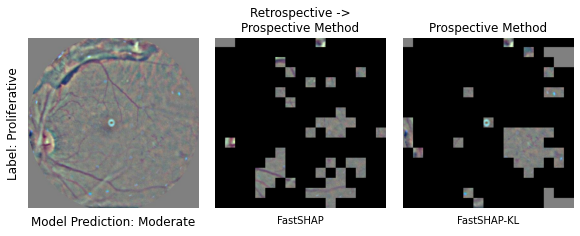

In [186]:
exp = 'Retinal Fundus Imaging'
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
fig_size = np.array([2.75 * (2 + 1), 3 * 1])
fig, axes = plt.subplots(nrows=1, 
                         ncols=2 + 1, 
                         figsize=fig_size)

im = x_dict[exp][sample[exp]].astype(np.float32)

# get a grayscale version of the image
if im.max() > 1:
    im /= 255.
if len(im.shape) == 3 and im.shape[2] == 3:
    im_gray = (0.2989 * im[:,:,0] + 0.5870 * im[:,:,1] + 0.1140 * im[:,:,2]) # rgb to gray
    im_disp = im
elif len(im.shape) == 3:
    im_gray = im.mean(2)
    # for non-RGB multi-channel data we show an RGB image where each of the three channels is a scaled k-mean center
    flat_vals = im.reshape([im.shape[0]*im.shape[1], im.shape[2]]).T
    flat_vals = (flat_vals.T - flat_vals.mean(1)).T
    means = kmeans(flat_vals, 3, round_values=False).data.T.reshape([im.shape[0], im.shape[1], 3])
    im_disp = (means - np.percentile(means, 0.5, (0,1))) / (np.percentile(means, 99.5, (0,1)) - np.percentile(means, 1, (0,1)))
    im_disp[im_disp > 1] = 1
    im_disp[im_disp < 0] = 0
else:
    im_gray = im
    im_disp = im

axes[0].imshow(im_disp, cmap=plt.get_cmap('gray'))
axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[0].set_frame_on(False)
axes[0].tick_params(length=0)

# Class Name
axes[0].set_ylabel('Label: {}'.format(class_names[y_dict[exp][sample[exp]].argmax()]), fontsize=12)
axes[0].set_xlabel('Model Prediction: {}'.format(class_names[pred_dict[exp][sample[exp]].argmax()]), fontsize=12)

for i, (x_type, ex) in enumerate(xplain_dict[exp].items()):
    
    # Select Correct Explanation and Model Prediction Class (if retro)
    if x_type == 'retro':
        ex = ex[pred_dict[exp][sample[exp]].argmax()][[sample[exp]]].squeeze()
    elif x_type == 'pro':
        ex = ex[[sample[exp]]].squeeze()
        
    # Get Top 10% of Features
    m = (ex >= np.percentile(ex, 85.)).astype(int)
    im_mask = im_disp * np.expand_dims(m, -1)
    
    #Get Max Val for color range
    abs_vals = np.abs(ex).flatten()
    max_val = np.max(abs_vals)
    if max_val == 0:
        max_val += 1e-8

    # Title
    if x_type == 'retro':
        axes[i+1].set_title('Retrospective ->\nProspective Method', fontsize=12)
        axes[i+1].set_xlabel('FastSHAP', fontsize=10)
    elif x_type == 'pro':
        axes[i+1].set_title('Prospective Method', fontsize=12)
        axes[i+1].set_xlabel('FastSHAP-KL', fontsize=10)
    

    #Plot
#     axes[i+1].imshow(im_gray, cmap=plt.get_cmap('gray'), alpha=0.3, extent=(-1, ex.shape[1], ex.shape[0], -1))
#     im = axes[i+1].imshow(ex, cmap=shap.plots.colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
    axes[i+1].imshow(im_mask, cmap=plt.get_cmap('gray'))
    axes[i+1].set_yticklabels([])
    axes[i+1].set_xticklabels([])
    axes[i+1].set_frame_on(False)
    axes[i+1].tick_params(length=0)
        
#Figure args
fig.tight_layout()
# plt.savefig(os.path.join('results', 'single_DR_explanations.pdf'))
plt.show()

### ECG

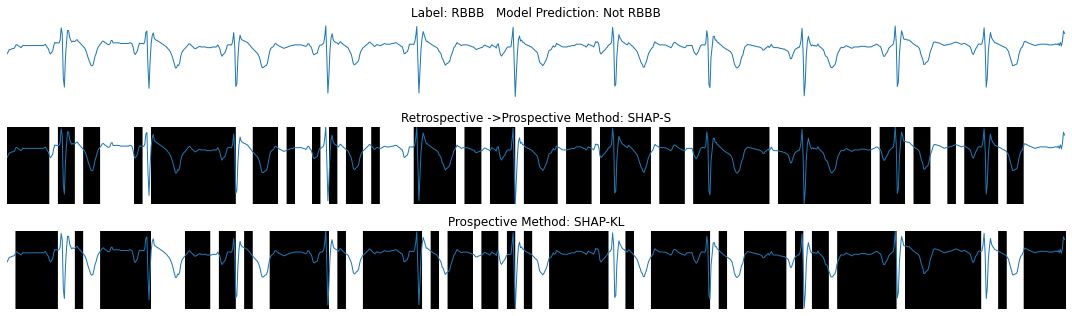

In [188]:
import matplotlib.ticker as ticker

### Plot
exp = 'ECG'
class_names = ['Not RBBB', 'RBBB']
fig_size = np.array([15, 1.5 * (3) ])
fig, axes = plt.subplots(nrows=3, 
                         ncols=1, 
                         figsize=fig_size, sharex=True)
                         

ecg = x_dict[exp][sample[exp]].astype(np.float32)
                         
axes[0].plot(ecg, linewidth=1.)
# Class Name
axes[0].set_title('Label: {}'.format(class_names[y_dict[exp][sample[exp]].argmax()]) + '   ' +
                  'Model Prediction: {}'.format(class_names[pred_dict[exp][sample[exp]].argmax()]), fontsize=12)
axes[0].set_xlim(0,1000)

axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[0].set_frame_on(False)
axes[0].tick_params(length=0)

for i, (x_type, ex) in enumerate(xplain_dict[exp].items()):
    
    # Select Correct Explanation and Model Prediction Class (if retro)
    if x_type == 'retro':
        ex = ex[pred_dict[exp][sample[exp]].argmax()][[sample[exp]]].squeeze()
    elif x_type == 'pro':
        ex = ex[[sample[exp]]].squeeze()
        
    # Get Top 10% of Features
    m = (ex >= np.percentile(ex, 70.)).astype(int)
    m = np.expand_dims(m.squeeze(), 0)
    
    #Get Max Val for color range
    abs_vals = np.abs(ex).flatten()
    max_val = np.max(abs_vals)
    if max_val == 0:
        max_val += 1e-8

    # Title
    if x_type == 'retro':
        axes[i+1].set_title('Retrospective ->Prospective Method: SHAP-S', fontsize=12)
    elif x_type == 'pro':
        axes[i+1].set_title('Prospective Method: SHAP-KL', fontsize=12)
#         axes[i+1].set_xlabel('Samples', fontsize=10)
    

    #Plot
    axes[i+1].plot(ecg, linewidth=1.)
    axes[i+1].imshow(m, 
                     aspect="auto",
                     cmap=plt.get_cmap('gray'),
                     extent=(0, ecg.shape[0], np.min(ecg), np.max(ecg)))
    axes[i+1].set_yticklabels([])
    axes[i+1].set_xticklabels([])
    axes[i+1].set_frame_on(False)
    axes[i+1].tick_params(length=0)

                         
fig.tight_layout()
# plt.savefig(os.path.join('results', 'single_DR_explanations.pdf'))
# plt.xticks(np.linspace(0,10, 1001))
plt.show()

# Mimic IV

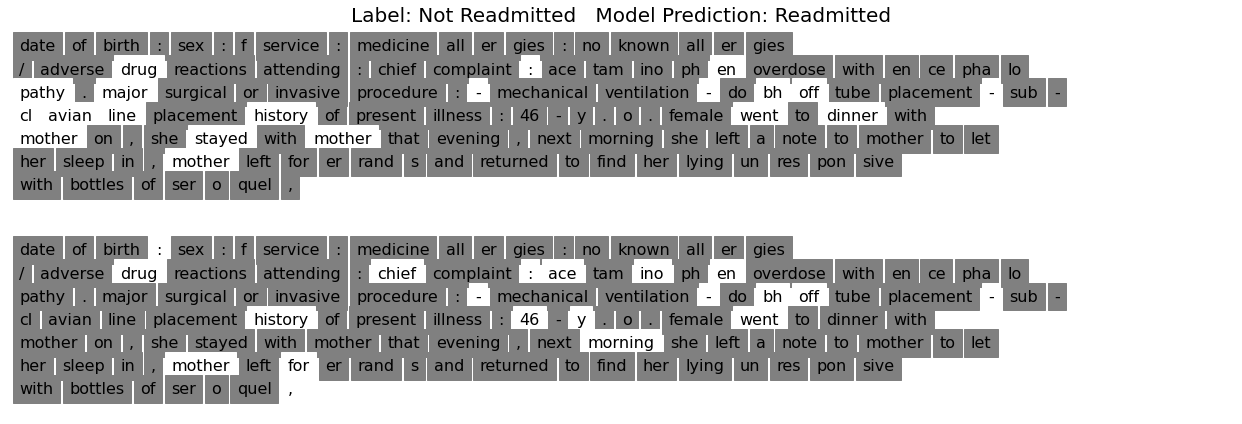

In [184]:
import matplotlib as mpl

exp = 'Discharge Summaries'
class_names = ['Not Readmitted', 'Readmitted']

#Set Figure
figsize = (18, 3 * 2)
fig, axes = plt.subplots(nrows=2, 
                         ncols=1, 
                         figsize=figsize)


# sample[exp] = 50

#Select Note
word_array = x_dict[exp][sample[exp]]

for i, (x_type, ex) in enumerate(xplain_dict[exp].items()):
    row = i
    
    # Select Correct Explanation and Model Prediction Class (if retro)
    if x_type == 'retro':
        ex = ex[pred_dict[exp][sample[exp]].argmax()][[sample[exp]]].squeeze()
    elif x_type == 'pro':
        ex = ex[[sample[exp]]].squeeze()
        
    # Get Top 10% of Features
    m = (ex >= np.percentile(ex, 85.)).astype(int)
    
    axis_transform = axes[row].transData

    axes[row].xaxis.set_visible(False) # make xaxis invisible
    plt.setp(axes[row].spines.values(), visible=False) # make spines (the box) invisible
    axes[row].tick_params(left=False, labelleft=False) # remove ticks and labels for the left axis
    axes[row].patch.set_visible(False) #remove background patch (only needed for non-white background)
#         axes[row].axis('off')

    # Title
    if row == 0:
        axes[0].set_title('Label: {}'.format(class_names[y_dict[exp][sample[exp]].argmax()]) + '   ' +
                          'Model Prediction: {}'.format(class_names[pred_dict[exp][sample[exp]].argmax()]), fontsize=20)

    # Method Name = y_label
    # Title
    if x_type == 'retro':
        axes[row].set_xlabel('Retrospective ->Prospective Method: SHAP-S', fontsize=12)
    elif x_type == 'pro':
        axes[row].set_xlabel('Prospective Method: SHAP-KL', fontsize=12)

    spacing = '     '
    space_text = axes[row].text(x=0.01,
                          y=1.0,
                          s=spacing,
                          transform=axis_transform)
    space_text.draw(fig.canvas.get_renderer())
    space_bounds = space_text.get_window_extent()
    
    vmin = -1
    vmax = 1

    normalizer = mpl.colors.Normalize(vmin=vmin,
                                      vmax=vmax)

    color_mapper = mpl.cm.ScalarMappable(norm=normalizer,
                                         cmap=plt.get_cmap('gray'))

    y_pos = 1.
    for j, (word, importance) in enumerate(zip(word_array, m)):

        fontweight = 500
        fontsize = 16
        if j % 20 == 0:
            y_pos -= .125
            axis_transform = axes[row].transData

        #Remove [CLS] and [SEP]
        if word in ['[CLS]', '[SEP]', '[PAD]']:
            continue

        zorder = 0

        word = word.replace('#', '')
        color = color_mapper.to_rgba(importance)
        text = axes[row].text(x=0.01,
                        y=y_pos,
                        s='{}'.format(word),
                        backgroundcolor=color,
                        fontsize=fontsize,
                        transform=axis_transform,
                        fontweight=fontweight,
                        zorder=zorder)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        axis_transform = mpl.transforms.offset_copy(text._transform,
                                                    x=ex.width + space_bounds.width,
                                                    units='dots')
    row+=1

fig.tight_layout()
# plt.savefig(os.path.join('results', 'mimic_explanations.pdf'))
plt.show()